In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, gaussian_laplace
import math
from math import sqrt, log
from scipy import spatial
from skimage.util import img_as_float
from skimage.feature.peak import peak_local_max
from skimage.feature._hessian_det_appx import _hessian_matrix_det
from skimage.transform import integral_image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from earl_nema import load_PET

In [2]:
# PET scan directory
time_step = 1
dicom_dir = ('../dicom/Teaghan/1.2.840._2362.263_PT_2019-12-09_174508_Upper.Extrem-_t'+
             str(time_step)+'.4p5min.TOF.QClear350_n89__00000')

In [3]:
# Load PET data
pet_scan, dz, dy, dx = load_PET(dicom_dir)

Reading dicom directory: ../dicom/Teaghan/1.2.840._2362.263_PT_2019-12-09_174508_Upper.Extrem-_t1.4p5min.TOF.QClear350_n89__00000
	Pet scan has shape: (89, 128, 128) and a resolution of (2.80, 5.47, 5.47)mm


In [4]:
# Process PET scan by clipping the low valued pixels 
# and the pixels above 40% of the max. Then we will
# normalize the pixel values between 0 and 255 to agree
# with typical greyscale values. 
# NOTE: this processed version of the scan will NOT be 
# used to calculate the RCs and COVs.
image = np.copy(pet_scan)
image = np.clip(image, 1, 0.4*np.max(image))
image = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype(np.uint8)

In [5]:
# Volumes of individual spheres based on phantom
volumes = np.array([26.52, 11.49, 5.57, 2.57, 1.15, 0.52]) * 1000 # mm^3
# Radii
radii = (3/(4*np.pi) * volumes )**(1/3) # mm
# Convert to pixels
radii_zyx = np.array([radii/dz, radii/dy, radii/dx])
# Convert to standard deviation units for Gaussian kernel
sigma_zyx = radii_zyx / np.sqrt(3)

# Limits for the standard deviation for Gaussian kernel for the blob detection
min_sigma = np.min(sigma_zyx, axis=1)
max_sigma = np.max(sigma_zyx, axis=1)

threshold=0.1
sigma_ratio=1.5
overlap=1e-5
exclude_border=False

In [6]:
def _compute_sphere_overlap(d, r1, r2):
    """
    Compute volume overlap fraction between two spheres of radii
    ``r1`` and ``r2``, with centers separated by a distance ``d``.
    Parameters
    ----------
    d : float
        Distance between centers.
    r1 : float
        Radius of the first sphere.
    r2 : float
        Radius of the second sphere.
    Returns
    -------
    fraction: float
        Fraction of volume of the overlap between the two spheres.
    Notes
    -----
    See for example http://mathworld.wolfram.com/Sphere-SphereIntersection.html
    for more details.
    """
    vol = (math.pi / (12 * d) * (r1 + r2 - d)**2 *
           (d**2 + 2 * d * (r1 + r2) - 3 * (r1**2 + r2**2) + 6 * r1 * r2))
    return vol / (4./3 * math.pi * min(r1, r2) ** 3)

def _blob_overlap(blob1, blob2, *, sigma_dim=1):
    """Finds the overlapping area fraction between two blobs.
    Returns a float representing fraction of overlapped area. Note that 0.0
    is *always* returned for dimension greater than 3.
    Parameters
    ----------
    blob1 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    blob2 : sequence of arrays
        A sequence of ``(row, col, sigma)`` or ``(pln, row, col, sigma)``,
        where ``row, col`` (or ``(pln, row, col)``) are coordinates
        of blob and ``sigma`` is the standard deviation of the Gaussian kernel
        which detected the blob.
    sigma_dim : int, optional
        The dimensionality of the sigma value. Can be 1 or the same as the
        dimensionality of the blob space (2 or 3).
    Returns
    -------
    f : float
        Fraction of overlapped area (or volume in 3D).
    """
    ndim = len(blob1) - sigma_dim
    if ndim > 3:
        return 0.0
    root_ndim = sqrt(ndim)

    # we divide coordinates by sigma * sqrt(ndim) to rescale space to isotropy,
    # giving spheres of radius = 1 or < 1.
    if blob1[-1] > blob2[-1]:
        max_sigma = blob1[-sigma_dim:]
        r1 = 1
        r2 = blob2[-1] / blob1[-1]
    else:
        max_sigma = blob2[-sigma_dim:]
        r2 = 1
        r1 = blob1[-1] / blob2[-1]
    pos1 = blob1[:ndim] / (max_sigma * root_ndim)
    pos2 = blob2[:ndim] / (max_sigma * root_ndim)

    d = np.sqrt(np.sum((pos2 - pos1)**2))
    if d > r1 + r2:  # centers farther than sum of radii, so no overlap
        return 0.0

    # one blob is inside the other
    if d <= abs(r1 - r2):
        return 1.0

    if ndim == 2:
        return _compute_disk_overlap(d, r1, r2)

    else:  # ndim=3 http://mathworld.wolfram.com/Sphere-SphereIntersection.html
        return _compute_sphere_overlap(d, r1, r2)
    
def _prune_blobs(blobs_array, overlap, *, sigma_dim=1):
    """Eliminated blobs with area overlap.
    Parameters
    ----------
    blobs_array : ndarray
        A 2d array with each row representing 3 (or 4) values,
        ``(row, col, sigma)`` or ``(pln, row, col, sigma)`` in 3D,
        where ``(row, col)`` (``(pln, row, col)``) are coordinates of the blob
        and ``sigma`` is the standard deviation of the Gaussian kernel which
        detected the blob.
        This array must not have a dimension of size 0.
    overlap : float
        A value between 0 and 1. If the fraction of area overlapping for 2
        blobs is greater than `overlap` the smaller blob is eliminated.
    sigma_dim : int, optional
        The number of columns in ``blobs_array`` corresponding to sigmas rather
        than positions.
    Returns
    -------
    A : ndarray
        `array` with overlapping blobs removed.
    """
    sigma = blobs_array[:, -sigma_dim:].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - sigma_dim)
    tree = spatial.cKDTree(blobs_array[:, :-sigma_dim])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if _blob_overlap(blob1, blob2, sigma_dim=sigma_dim) > overlap:
                # note: this test works even in the anisotropic case because
                # all sigmas increase together.
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])

In [7]:
image = img_as_float(image)

# if both min and max sigma are scalar, function returns only one sigma
scalar_sigma = np.isscalar(max_sigma) and np.isscalar(min_sigma)

# Gaussian filter requires that sequence-type sigmas have same
# dimensionality as image. This broadcasts scalar kernels
if np.isscalar(max_sigma):
    max_sigma = np.full(image.ndim, max_sigma, dtype=float)
if np.isscalar(min_sigma):
    min_sigma = np.full(image.ndim, min_sigma, dtype=float)

# Convert sequence types to array
min_sigma = np.asarray(min_sigma, dtype=float)
max_sigma = np.asarray(max_sigma, dtype=float)

# k such that min_sigma*(sigma_ratio**k) > max_sigma
k = int(np.mean(np.log(max_sigma / min_sigma) / np.log(sigma_ratio) + 1))

# a geometric progression of standard deviations for gaussian kernels
sigma_list = np.array([min_sigma * (sigma_ratio ** i)
                       for i in range(k + 1)])

gaussian_images = [gaussian_filter(image, s) for s in sigma_list]

# computing difference between two successive Gaussian blurred images
# multiplying with average standard deviation provides scale invariance
dog_images = [(gaussian_images[i] - gaussian_images[i + 1])
              * np.mean(sigma_list[i]) for i in range(k)]

image_cube = np.stack(dog_images, axis=-1)

# local_maxima = get_local_maxima(image_cube, threshold)
local_maxima = peak_local_max(image_cube, threshold_abs=threshold,
                              footprint=np.ones((3,) * (image.ndim + 1)),
                              threshold_rel=0.0,
                              exclude_border=exclude_border)
# Catch no peaks
if local_maxima.size == 0:
    blobs =  np.empty((0, 3))

# Convert local_maxima to float64
lm = local_maxima.astype(np.float64)

# translate final column of lm, which contains the index of the
# sigma that produced the maximum intensity value, into the sigma
sigmas_of_peaks = sigma_list[local_maxima[:, -1]]

if scalar_sigma:
    # select one sigma column, keeping dimension
    sigmas_of_peaks = sigmas_of_peaks[:, 0:1]

# Remove sigma index and replace with sigmas
lm = np.hstack([lm[:, :-1], sigmas_of_peaks])

sigma_dim = sigmas_of_peaks.shape[1]

blobs = _prune_blobs(lm, overlap, sigma_dim=sigma_dim)

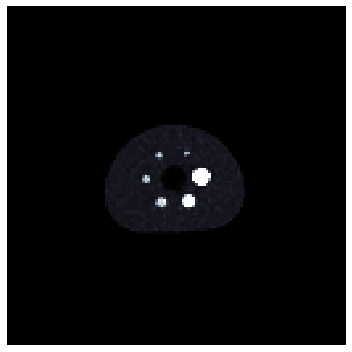

In [8]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(pet_scan[35], vmax=0.5*np.max(pet_scan), cmap='bone')
ax.set_axis_off()
plt.tight_layout()
plt.show()

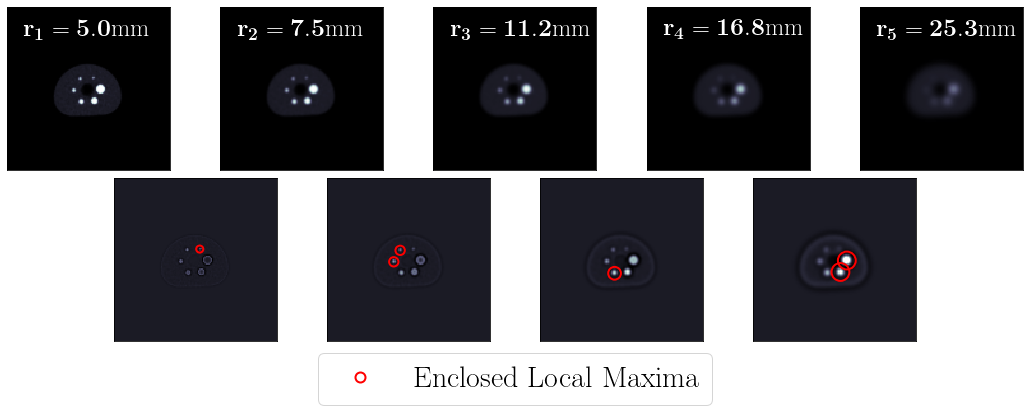

In [9]:
fig = plt.figure(figsize=(15,6))

gs = gridspec.GridSpec(2, 10)

# Create axes
axs = []
for i in range(2):
    for j in range(0,10,2):
        if (j+i+2)>10:
            continue
        axs.append(plt.subplot(gs[i, j+i:j+i+2]))
        axs[-1].tick_params(labelleft=False, labelbottom=False, length=0)

# Plot
for i, (ax, img) in enumerate(zip(axs, gaussian_images+dog_images)):
    if i<5:
        ax.annotate(r'$\mathbf{r_{%i}=%0.1f\mathrm{mm}}$' % (i+1, sigma_list[i,0]*np.sqrt(3)*dz), (0.1,0.8), 
                    xycoords='axes fraction', fontsize=25, color='w')
        vmin=0.
        vmax=1.
    else:
        vmin=-0.07
        vmax=0.5
    ax.imshow(img[35], cmap='bone', vmin=vmin, vmax=vmax)
    if i>=5:
        # Collect local maxima
        pts = local_maxima[local_maxima[:,-1]==(i-5),:-1]
        for (z,y,x) in pts:
            # Plot circles
            c = plt.Circle((x, y), sigma_list[i-5,0]*np.sqrt(3)+1, color='red', linewidth=2, fill=False)
            ax.add_patch(c)
            #ax.scatter(x,y, c='r')
# Legend
c = Line2D(range(1), range(1), color='white', marker='o', markeredgewidth=2, markeredgecolor='red', markersize=10)
fig.legend(handles=[c], labels=['Enclosed Local Maxima'], loc='lower center', fontsize=30)

# Display
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()